[*********************100%***********************]  1 of 1 completed


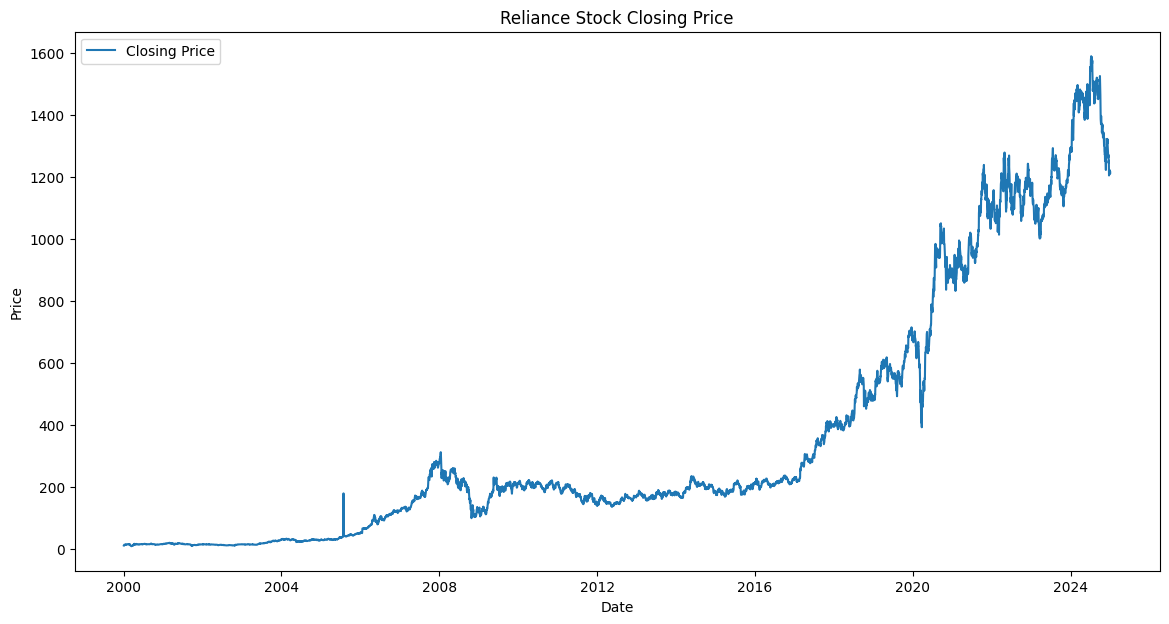

C:\Users\harik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - loss: 0.0023 - val_loss: 0.0125
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


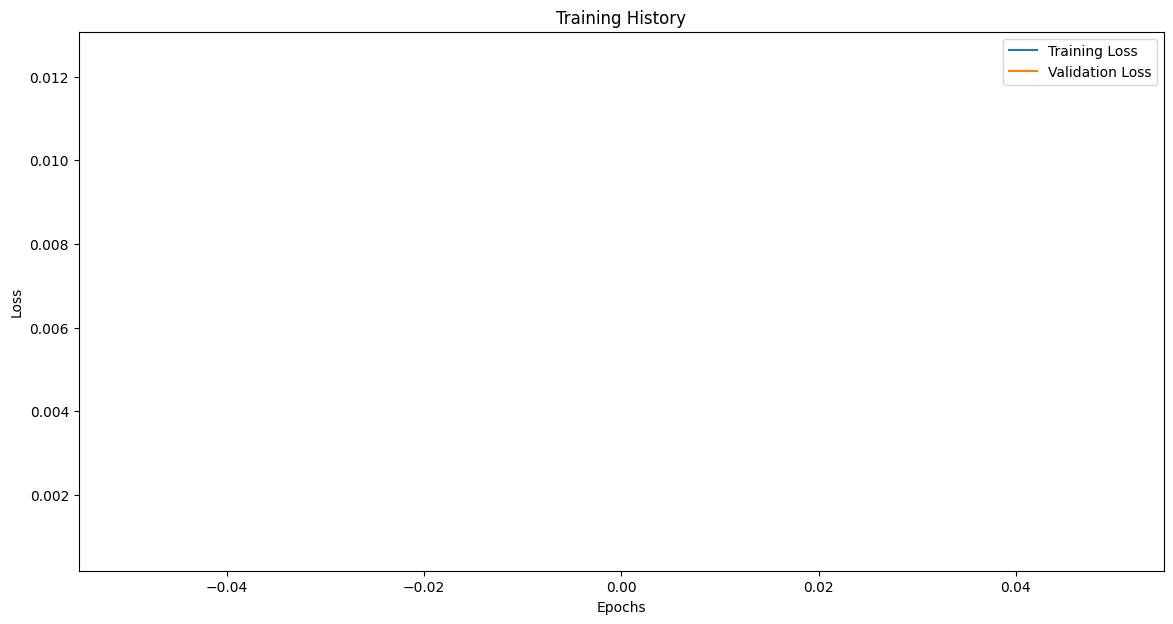

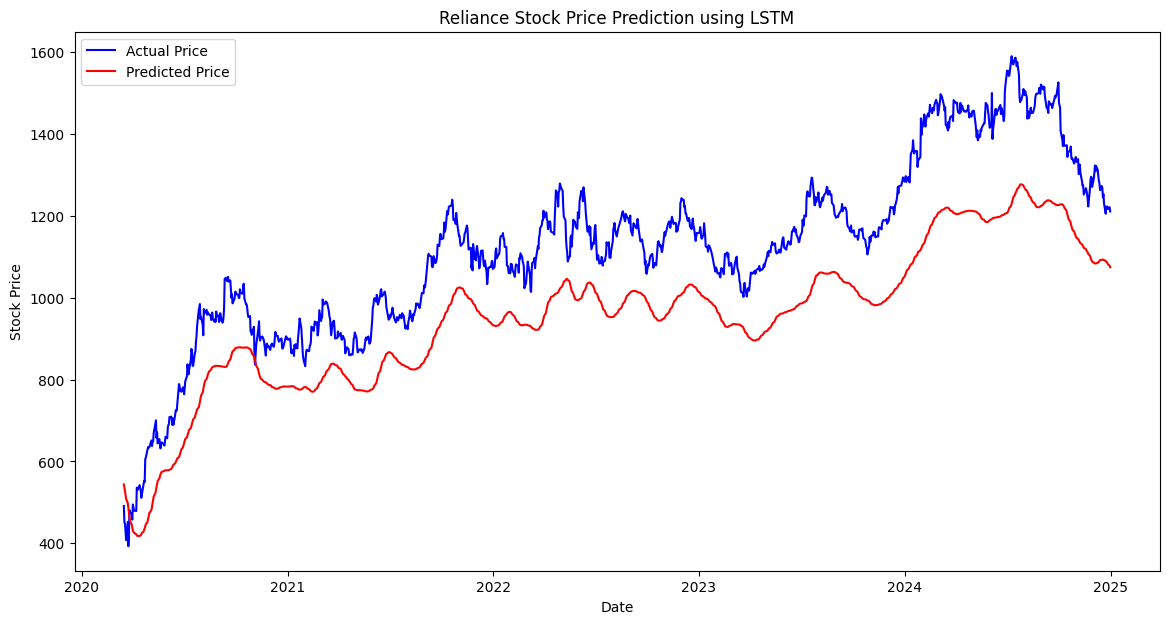

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104

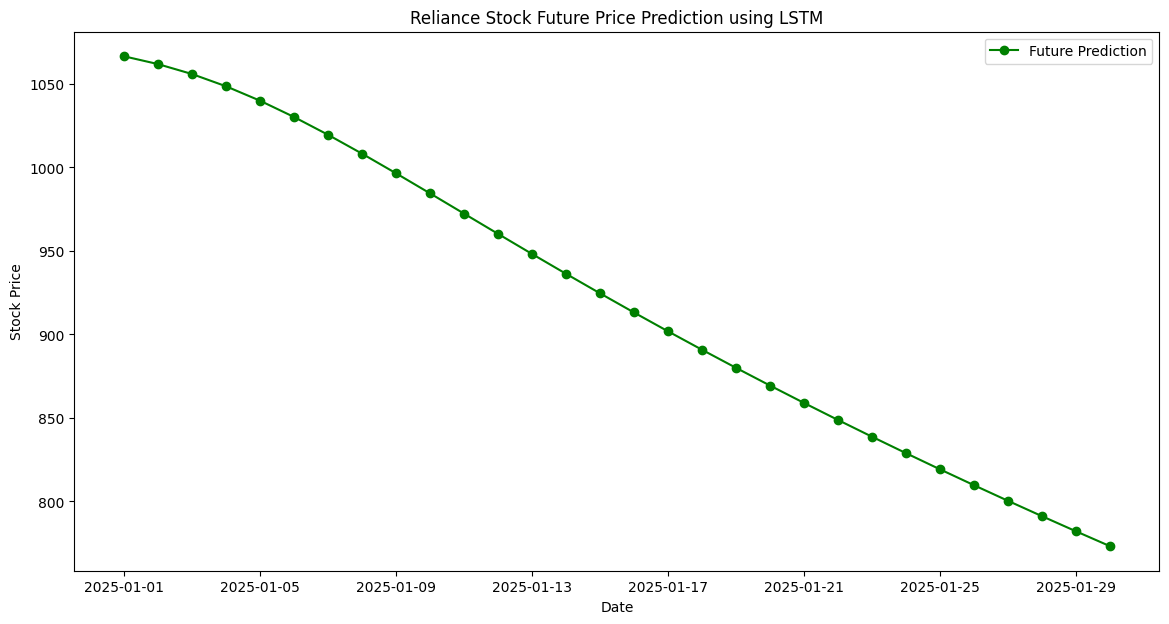

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Fetch Reliance stock data
ticker = 'RELIANCE.NS'  # NSE ticker for Reliance Industries
data = yf.download(ticker, start='2000-01-01', end='2025-01-01')

# Visualize raw data
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Reliance Stock Closing Price')
plt.show()

# Preprocess data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data[['Close']])

# Prepare training data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences
time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train, 
    epochs=1, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot training history
if 'loss' in history.history and len(history.history['loss']) > 0:
    plt.figure(figsize=(14,7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()
else:
    print("No loss values recorded.")

# Plot results
plt.figure(figsize=(14,7))
plt.plot(data.index[train_size + time_step + 1:train_size + time_step + 1 + len(y_test)], y_test, label='Actual Price', color='blue')
plt.plot(data.index[train_size + time_step + 1:train_size + time_step + 1 + len(test_predict)], test_predict, label='Predicted Price', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Reliance Stock Price Prediction using LSTM')
plt.show()

# Future Prediction
future_days = 30
last_sequence = test_data[-time_step:]
future_predictions = []

for _ in range(future_days):
    last_sequence = last_sequence.reshape(1, time_step, 1)
    pred = model.predict(last_sequence)
    future_predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[pred[0, 0]]]).reshape(1, time_step, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot Future Predictions
future_dates = pd.date_range(start=data.index[-1], periods=future_days+1)[1:]
plt.figure(figsize=(14,7))
plt.plot(future_dates, future_predictions, 'go-', label='Future Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Reliance Stock Future Price Prediction using LSTM')
plt.show()
